In [2]:
#!pip install darts

# New section

In [ ]:
!python -m pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
import logging

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

In [5]:
df = pd.read_csv('monthly_in_situ_co2_mlo.csv',
                  comment = '"', header = [0,1,2], na_values = '-99.99')

cols = [' '.join(col).replace(' ', '') for col in df.columns.values]
df.set_axis(cols, axis = 1, inplace = True)

# Converting Excel date format to datetime
# and setting as dataframe index
df['datetime'] = pd.to_datetime(df['DateExcel'], origin = '1899-12-30', unit = 'D')

df.set_index('datetime', inplace = True)

df = df[['CO2filled[ppm]']]
df.rename(columns = {'CO2filled[ppm]': 'CO2'}, inplace = True)
df.dropna(inplace = True)
df = df.resample('M').sum()

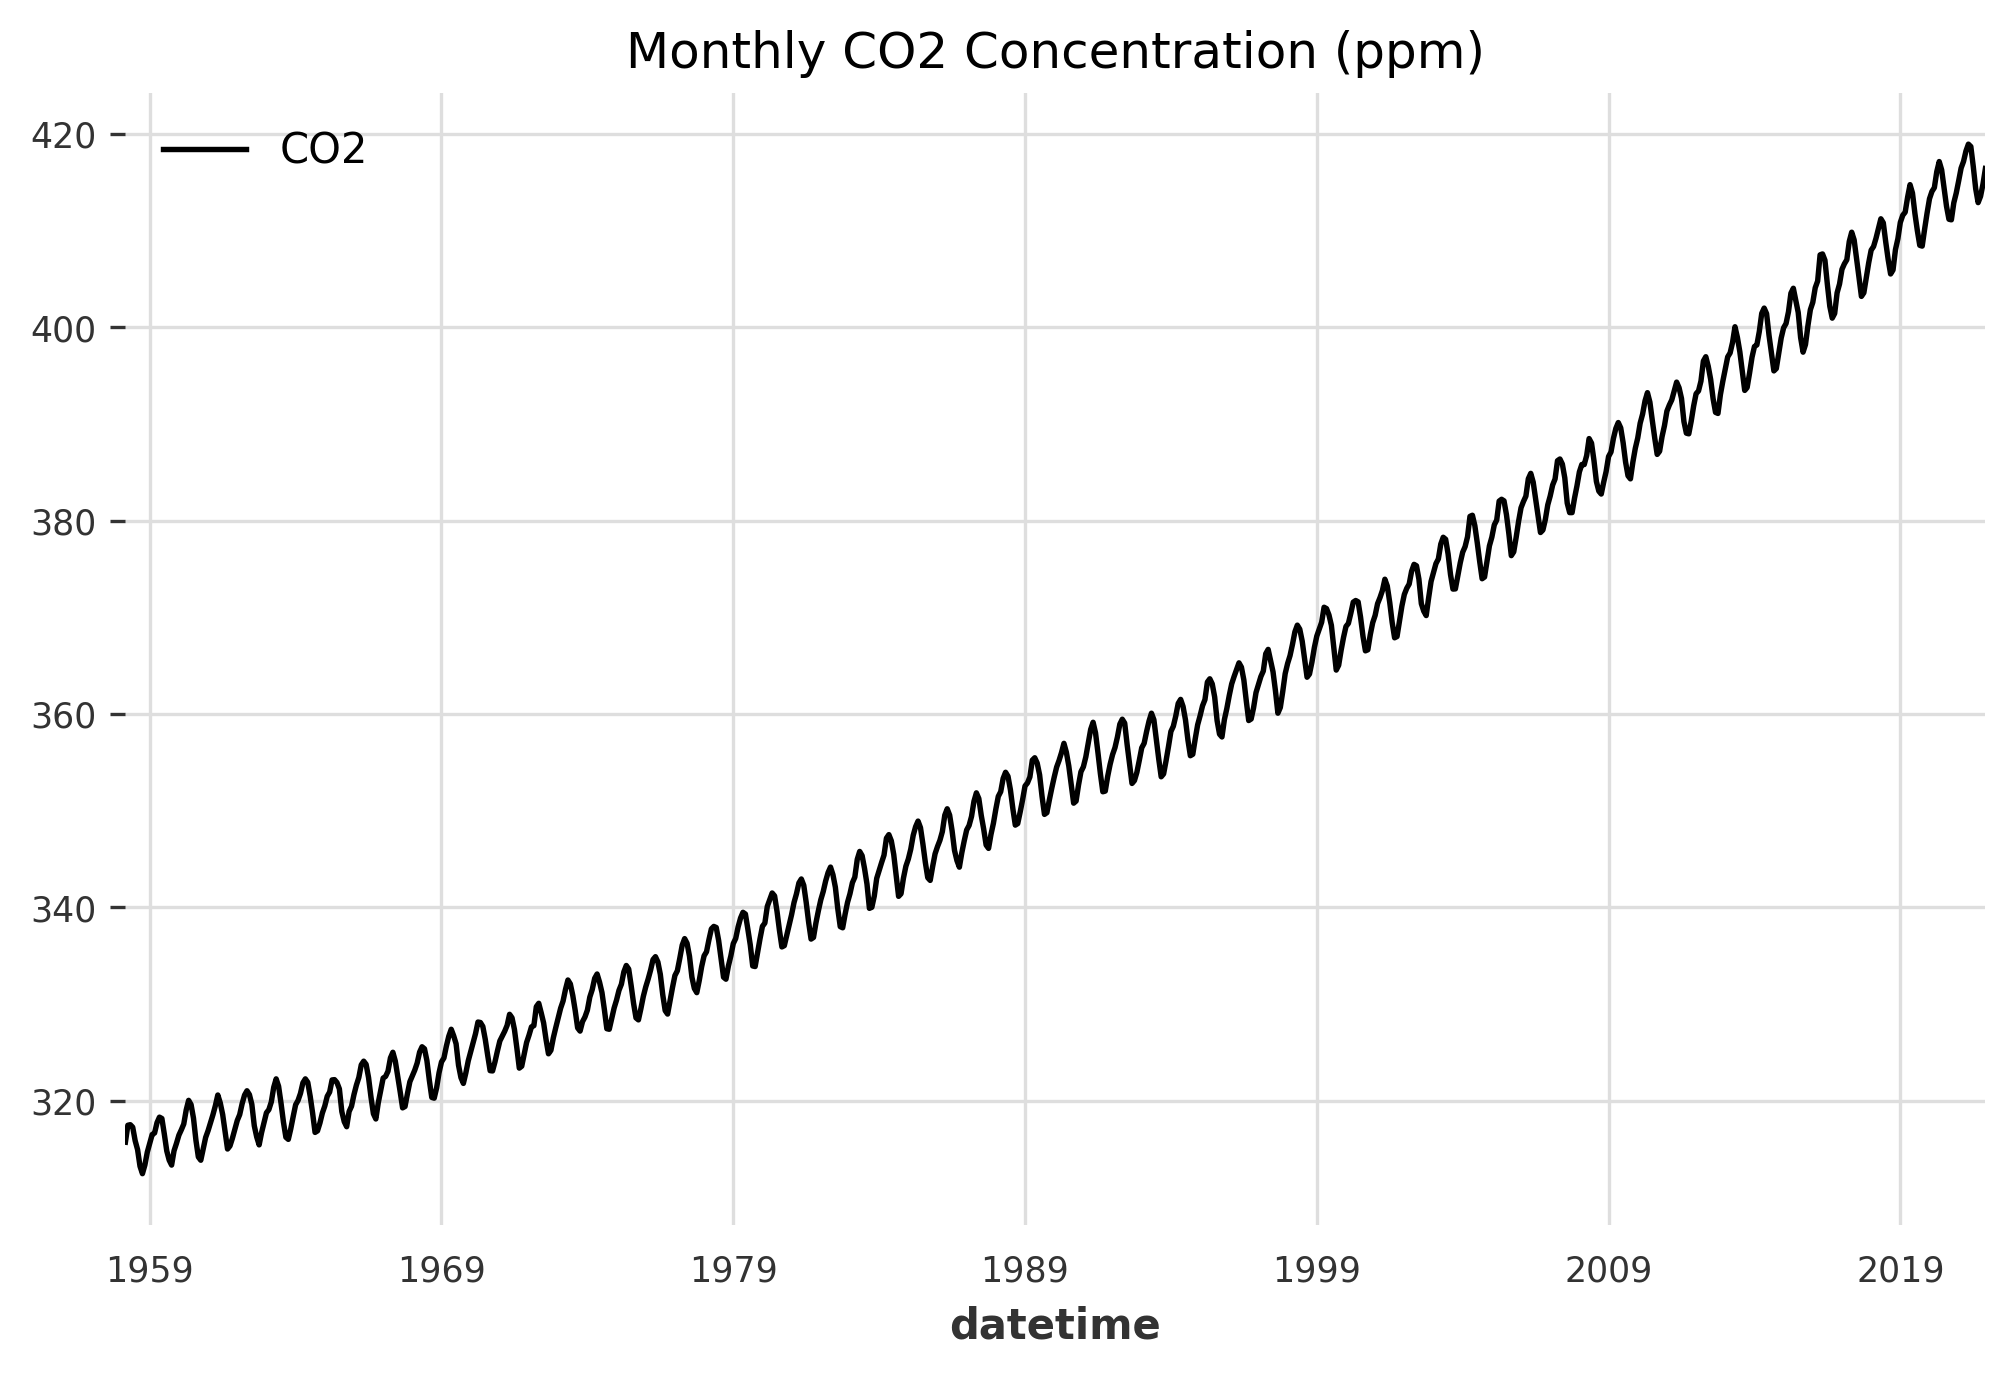

In [6]:
df.plot(figsize=(8,5))
plt.title('Monthly CO2 Concentration (ppm)')

plt.show()

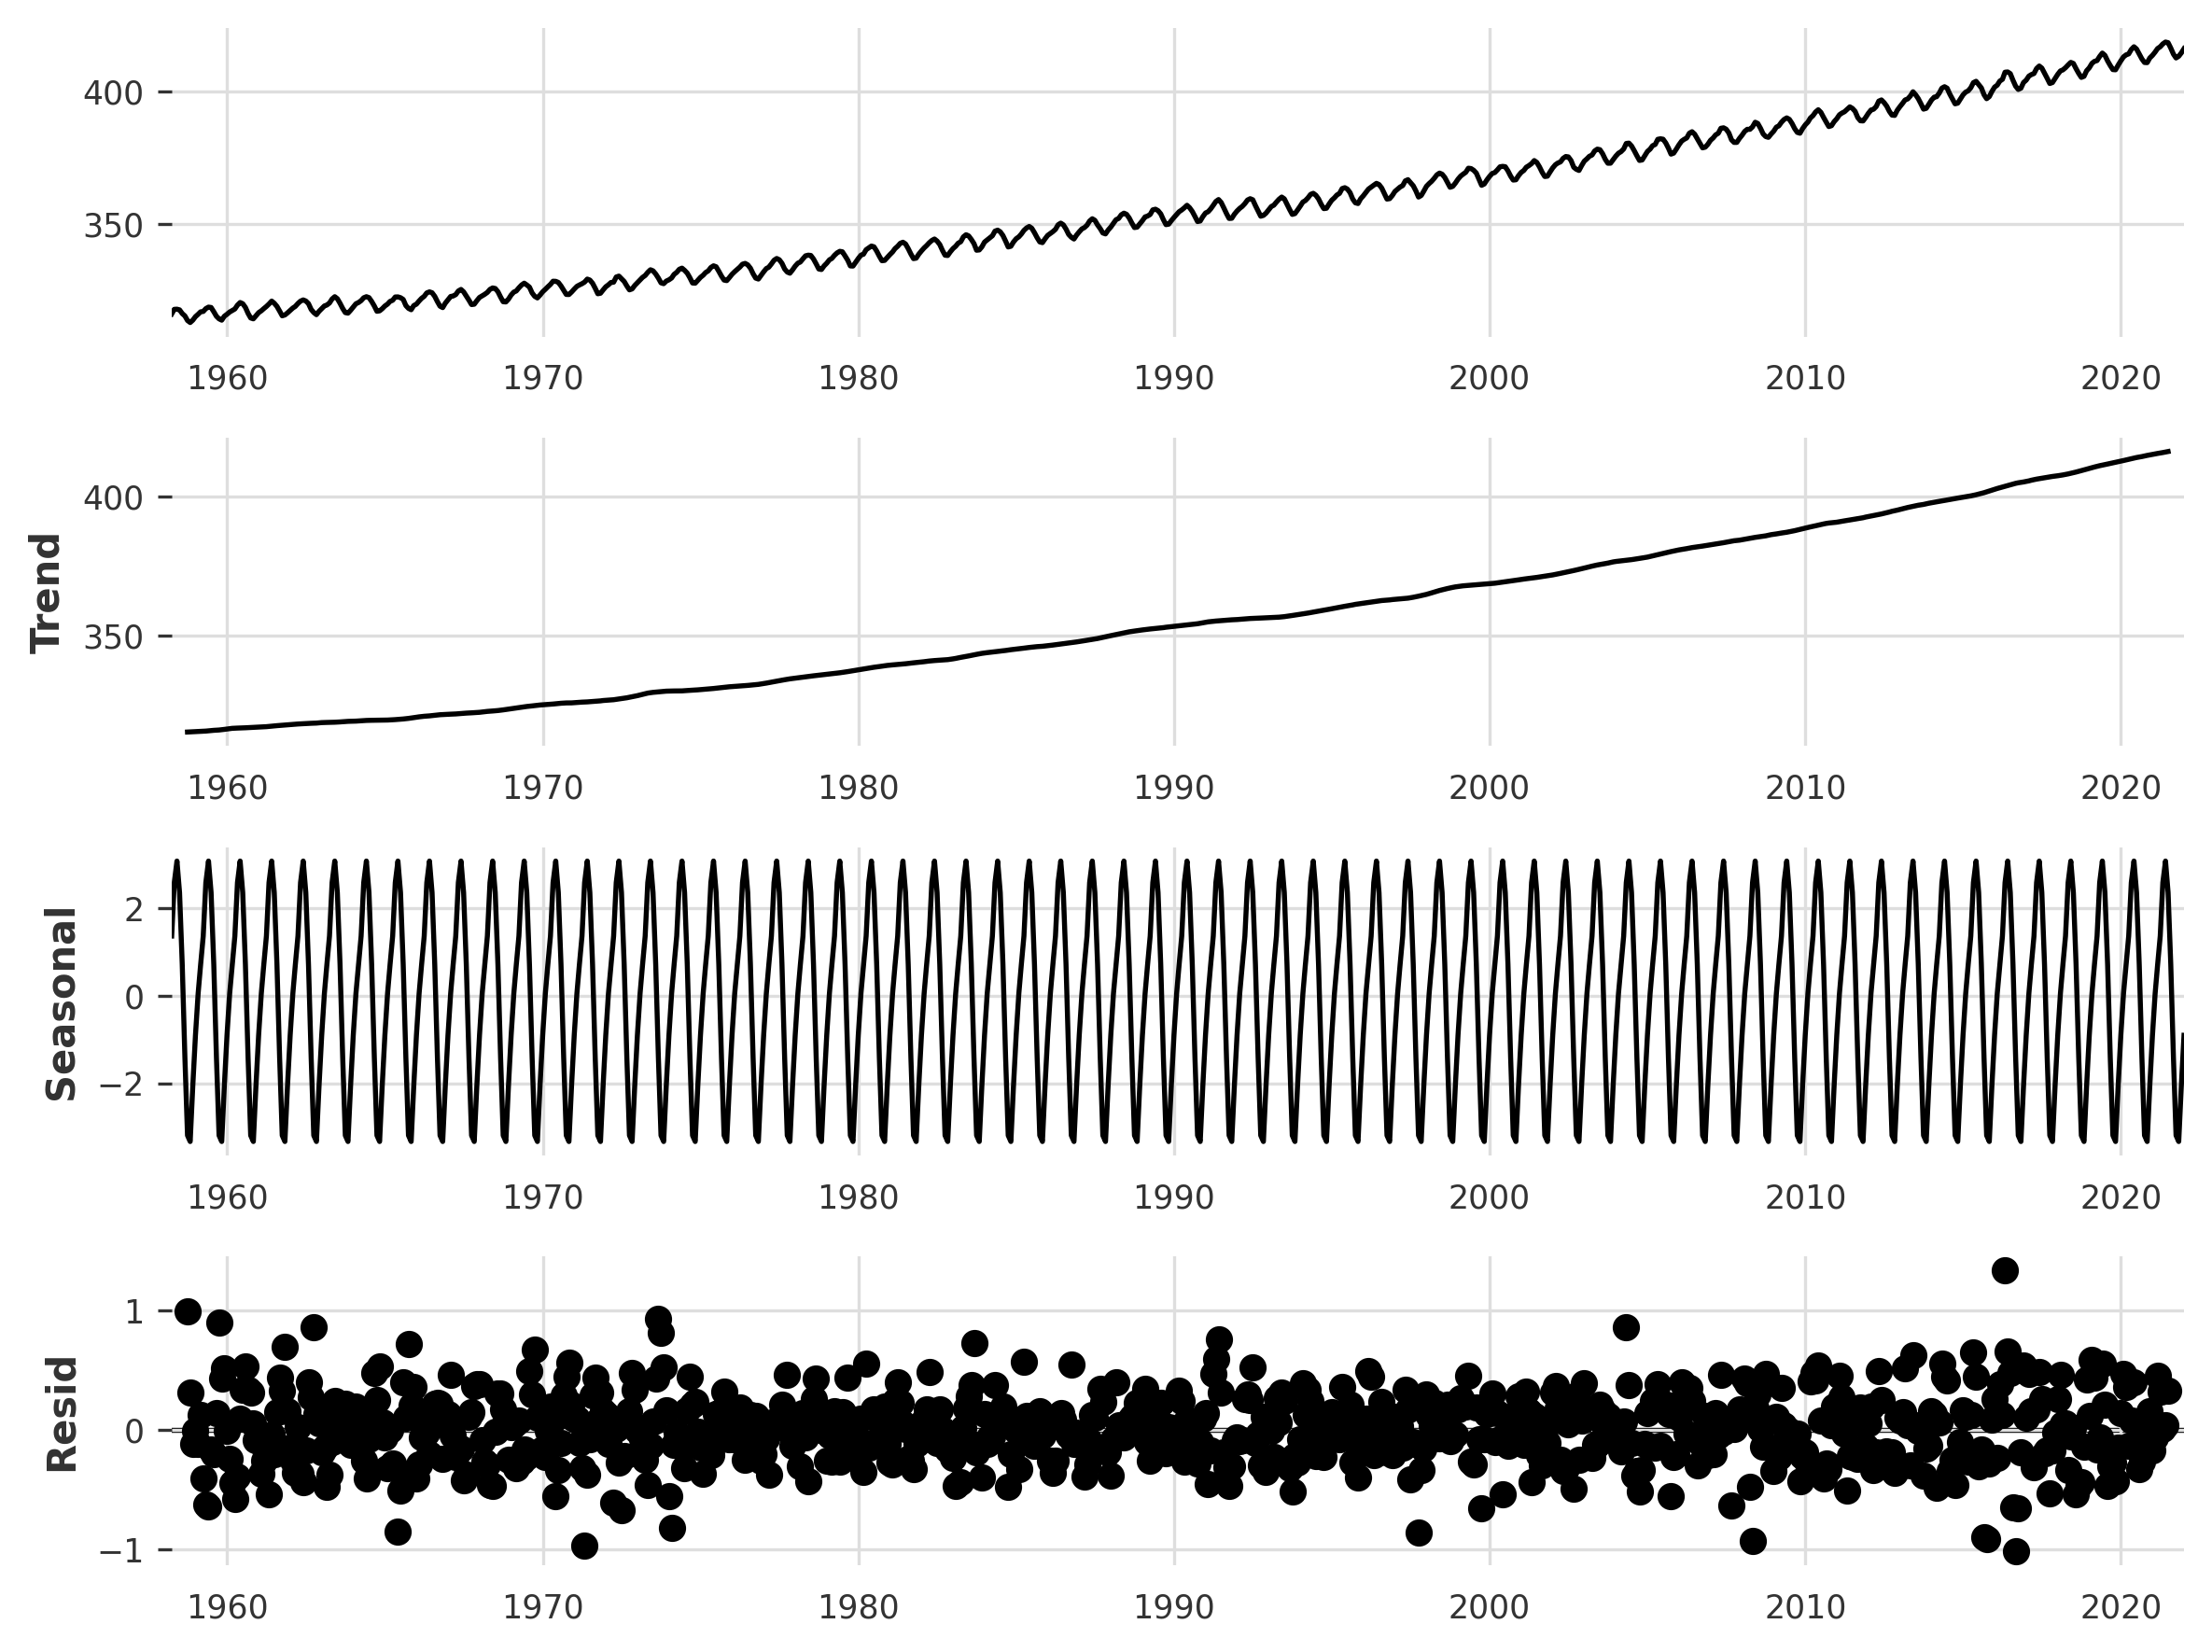

In [7]:
mpl.rcParams['figure.figsize'] = (8, 6)

result = seasonal_decompose(df)
result.plot()

plt.show()

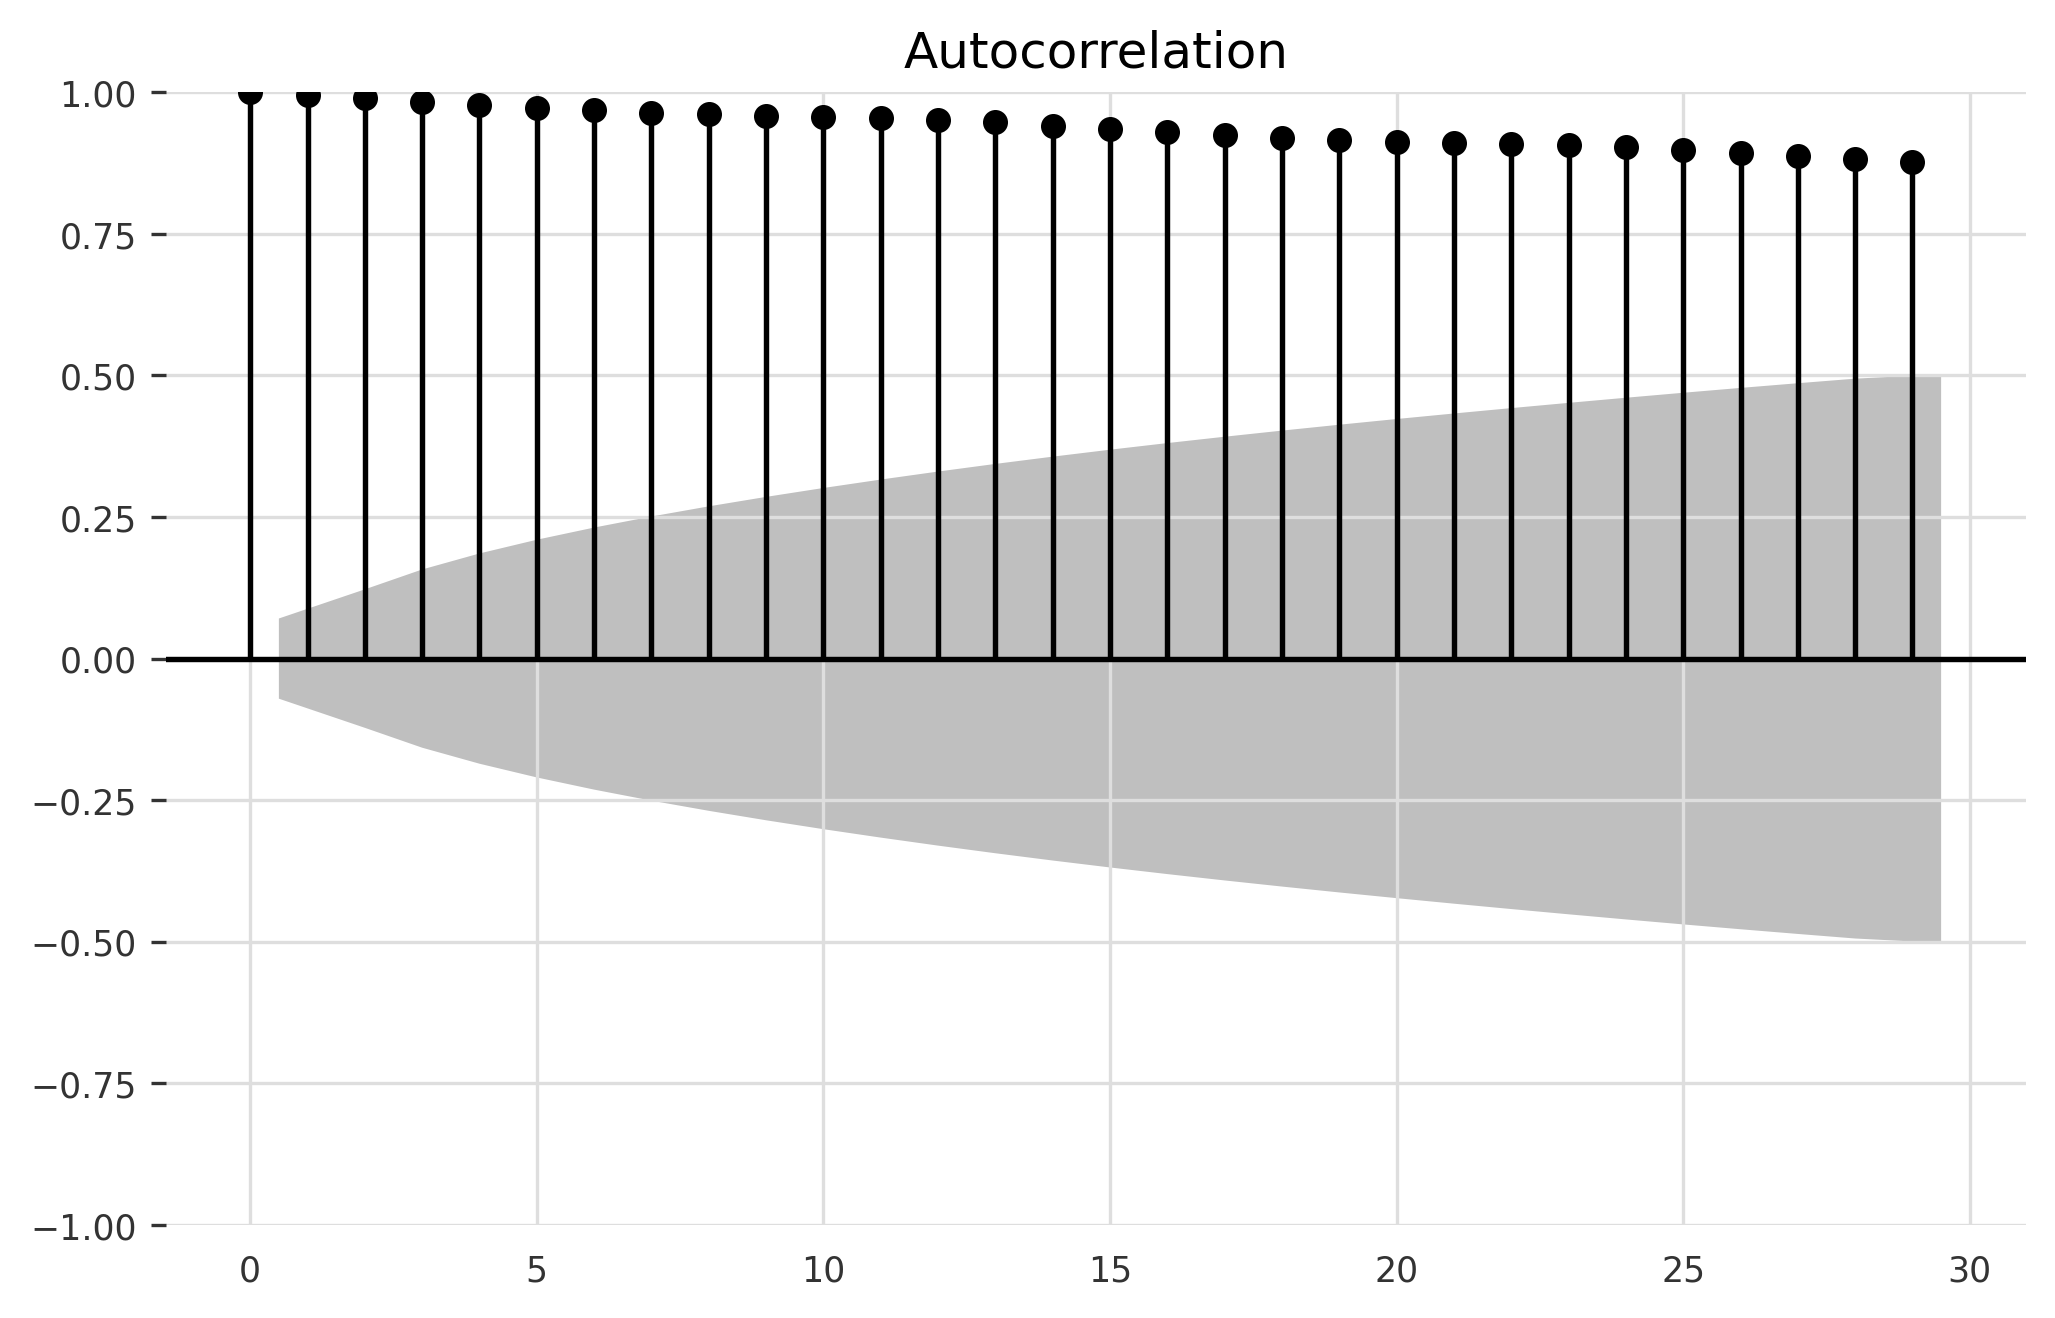

In [8]:
fig, ax = plt.subplots(figsize = (8,5))

plot_acf(df, ax = ax)

plt.show()

In [19]:
df

,CO2
datetime,
1958-03-31,315.70
1958-04-30,317.45
1958-05-31,317.51
1958-06-30,317.25
1958-07-31,315.86
...,...
2021-08-31,414.34
2021-09-30,412.90
2021-10-31,413.55


In [9]:
#Loading the pandas dataframe to a TimeSeries object as required by the Darts library
series = TimeSeries.from_dataframe(df)

start = pd.Timestamp('123115')
df_metrics = pd.DataFrame()

In [10]:
series

<TimeSeries (DataArray) (datetime: 766, component: 1, sample: 1)>
array([[[315.7 ]],

       [[317.45]],

       [[317.51]],

       [[317.25]],

       [[315.86]],

       [[314.93]],

       [[313.21]],

       [[312.44]],

       [[313.33]],

       [[314.67]],

...

       [[417.16]],

       [[418.24]],

       [[418.95]],

       [[418.7 ]],

       [[416.65]],

       [[414.34]],

       [[412.9 ]],

       [[413.55]],

       [[414.82]],

       [[416.43]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 1958-03-31 1958-04-30 ... 2021-12-31
  * component  (component) object 'CO2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [11]:
def plot_backtest(series, forecast, model_name):
    idx = -144
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()
    
def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_, 
             'R2': r2_score_}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    return(df.round(decimals = 2))       
    

100%|██████████| 62/62 [00:00<00:00, 64.57it/s]


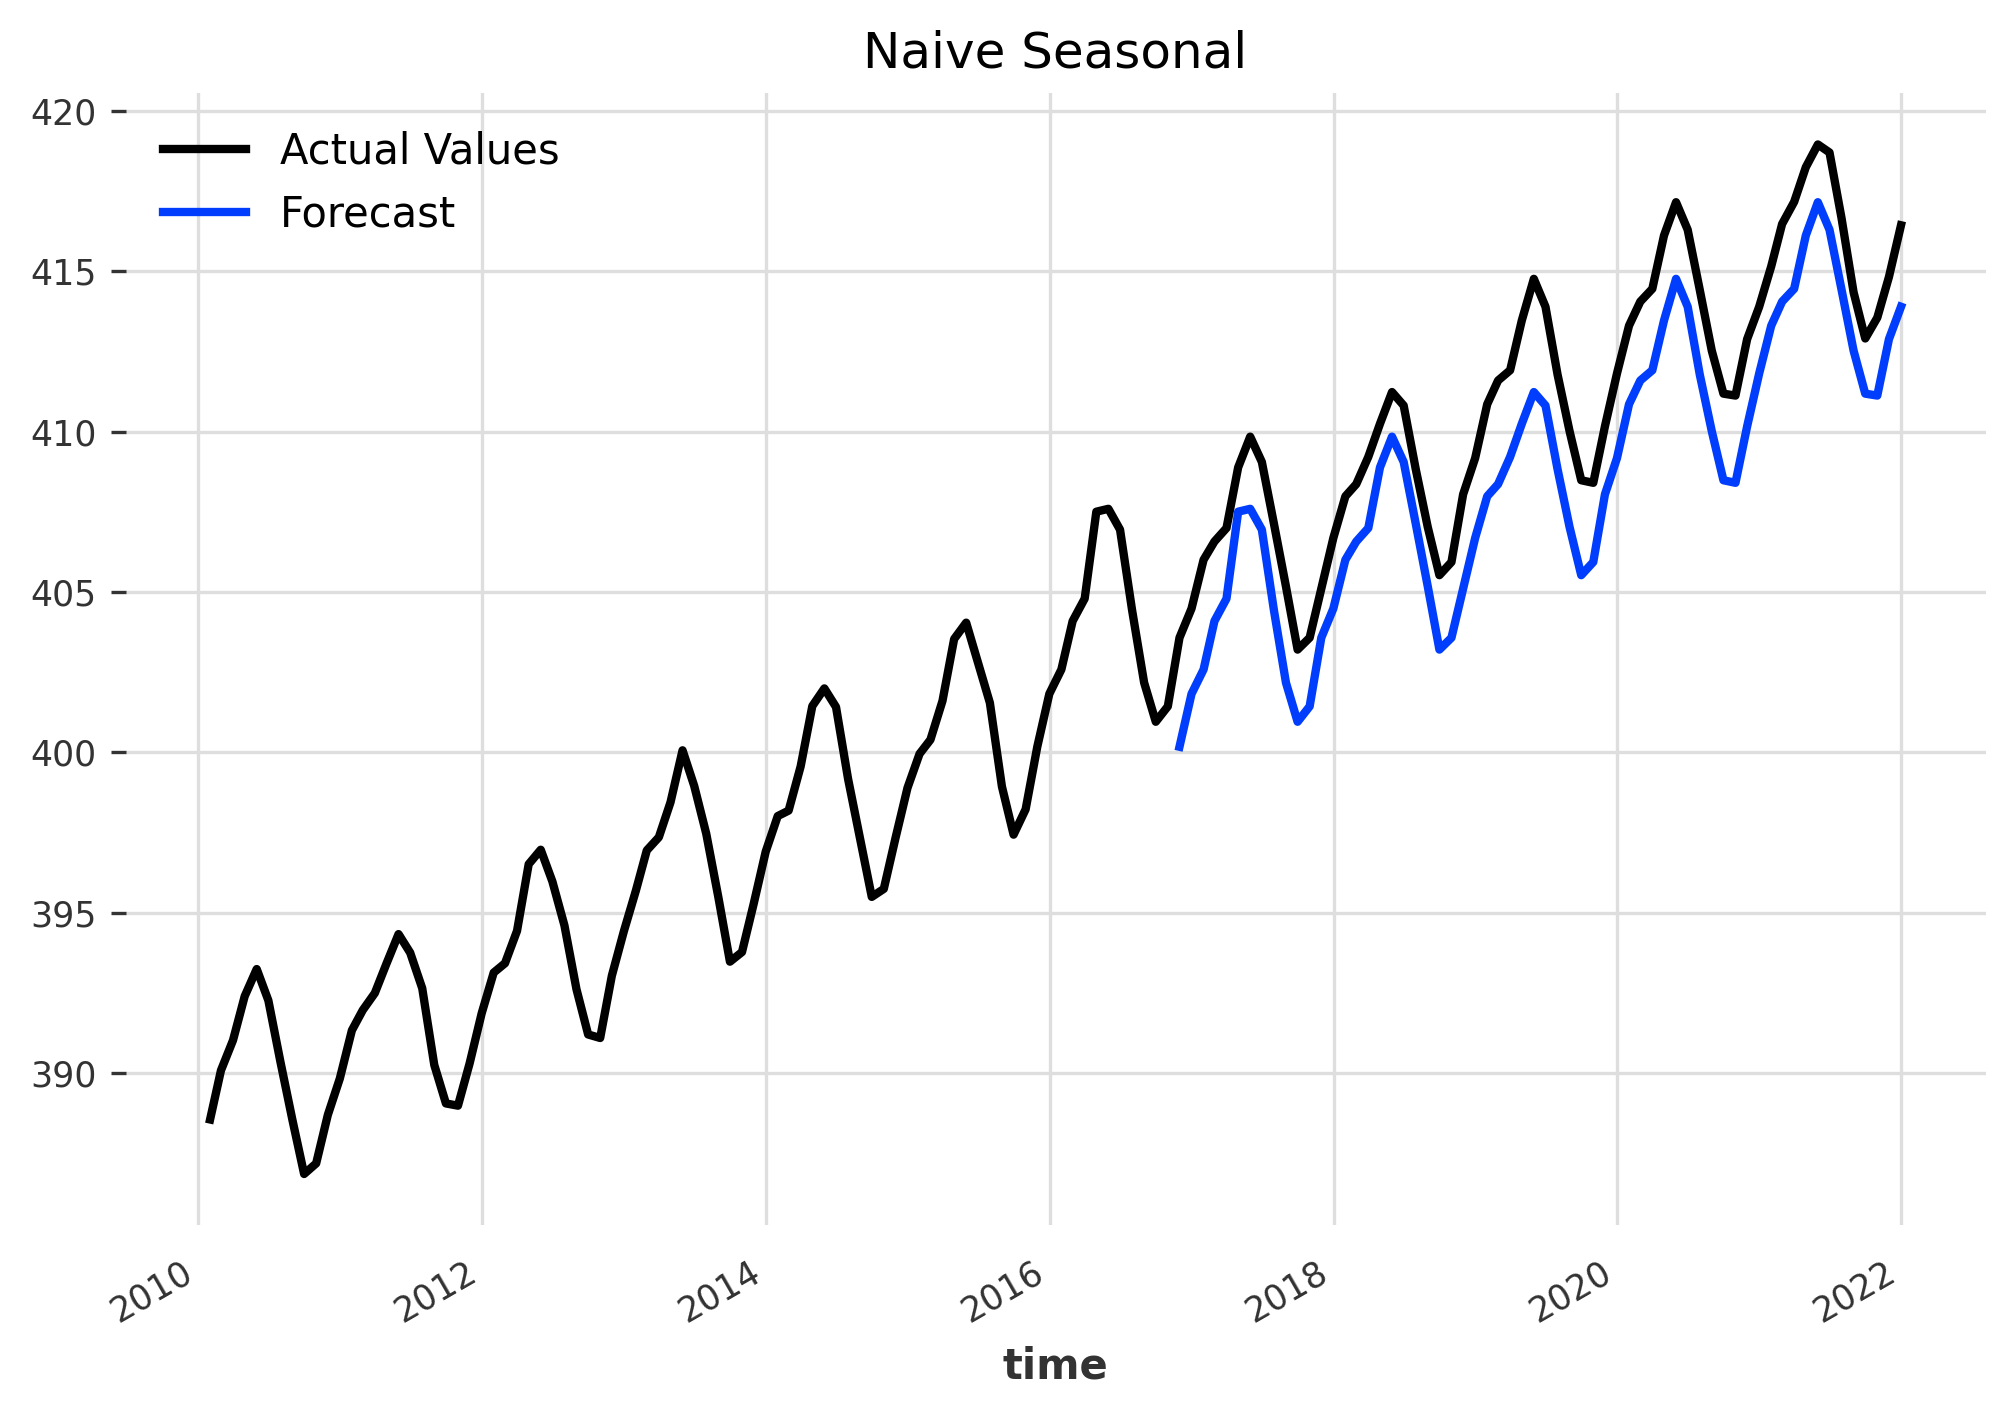

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.4,2.45,0.58,0.59,0.64


In [12]:
model = NaiveSeasonal(K = 12)
model_name = 'Naive Seasonal'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(series, forecast, model_name)
df_naive = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_naive)

plt.show()
df_naive

In [24]:
forecast.pd_dataframe().to_csv("Naive forecast.csv")

100%|██████████| 62/62 [00:23<00:00,  2.62it/s]


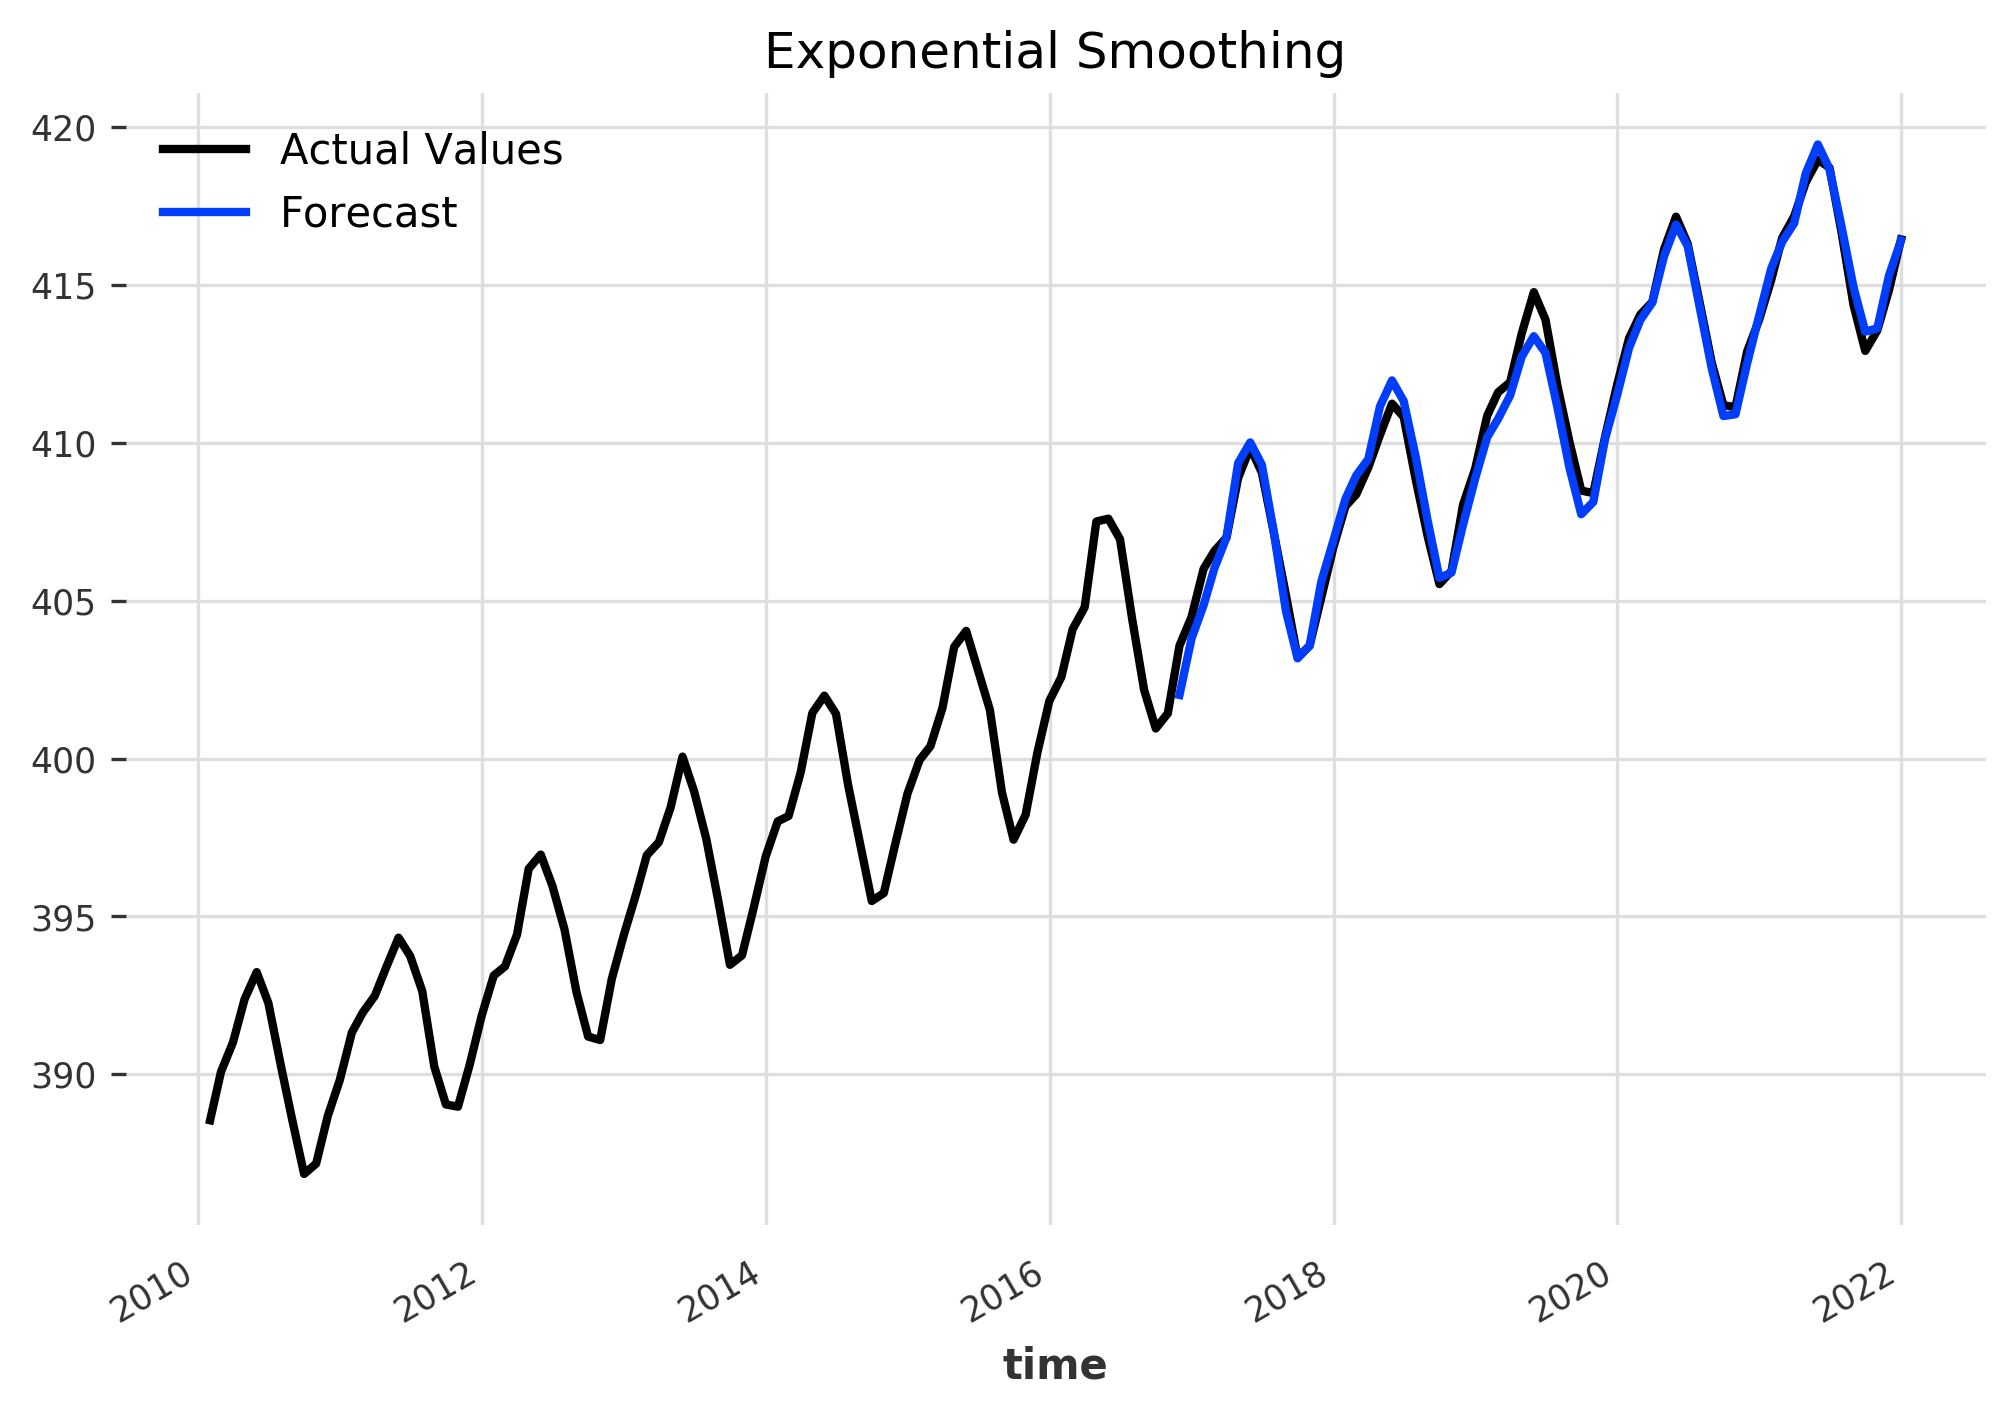

,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing,0.41,0.53,0.1,0.1,0.98


In [ ]:
model = ExponentialSmoothing(seasonal_periods = 12)
model_name = 'Exponential Smoothing'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(series, forecast, model_name)
df_exp = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_exp)

plt.show()
df_exp

100%|██████████| 62/62 [00:03<00:00, 18.44it/s]


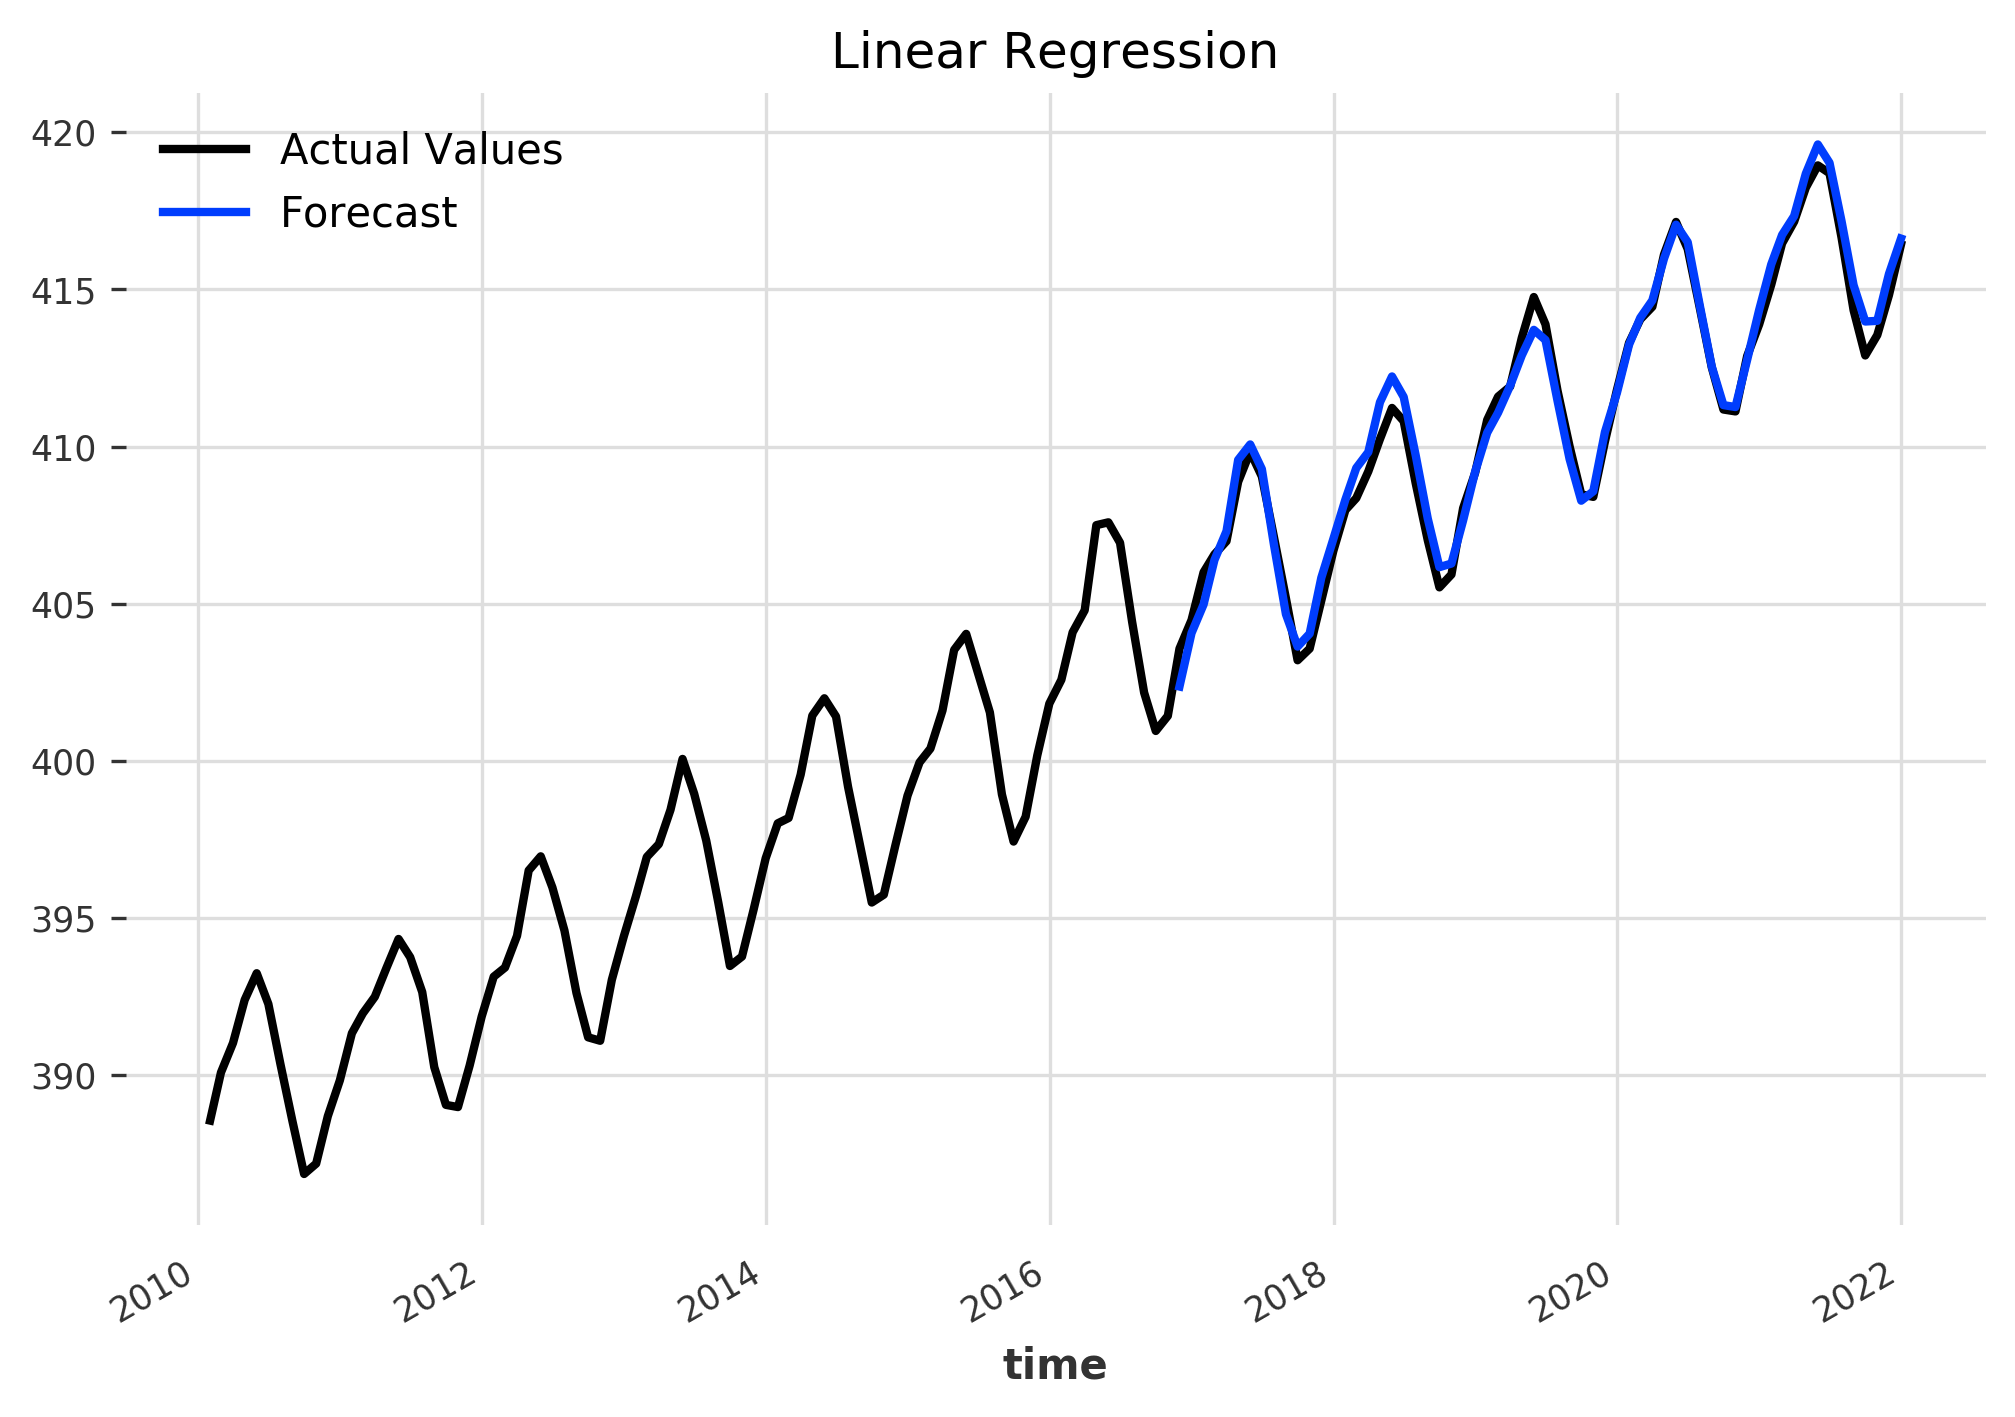

,MAE,RMSE,MAPE,SMAPE,R2
Linear Regression,0.44,0.54,0.11,0.11,0.98


In [ ]:
model = LinearRegressionModel(lags = 12)
model_name = 'Linear Regression'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(series, forecast, model_name)
df_lr = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_lr)

plt.show()
df_lr

In [ ]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    dropout=0.1,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)

model_name = 'TCN'

plt.figure(figsize = (8, 5))

scaler = Scaler()
scaled_series = scaler.fit_transform(series)
forecast = model.historical_forecasts(scaled_series, start=start,
                                      forecast_horizon=12, verbose=True)
plot_backtest(series, scaler.inverse_transform(forecast), model_name)
df_dl = print_metrics(series, scaler.inverse_transform(forecast), model_name)
df_metrics = df_metrics.append(df_dl)

plt.show()
df_dl

  0%|          | 0/62 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 21it [00:00, ?it/s]

  2%|▏         | 1/62 [00:33<33:33, 33.00s/it]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Predicting: 21it [00:00, ?it/s]

  3%|▎         | 2/62 [00:58<28:26, 28.44s/it]

Training: 0it [00:00, ?it/s]

Predicting: 10it [00:00, ?it/s]

  5%|▍         | 3/62 [01:23<26:41, 27.14s/it]

Training: 0it [00:00, ?it/s]

Predicting: 1it [00:00, ?it/s]

  6%|▋         | 4/62 [01:24<16:04, 16.63s/it]

Training: 0it [00:00, ?it/s]

Predicting: 13it [00:00, ?it/s]

  8%|▊         | 5/62 [01:26<10:44, 11.30s/it]

Training: 0it [00:00, ?it/s]